In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from training.data.datasets.nuscenes_sparse import NuScenesDataset
from types import SimpleNamespace

In [2]:
from training.data.datasets.vkitti import VKittiDataset

In [3]:
DATA_ROOT = "/fs/scratch/PAS2099/dataset/nuscenes/v1.0-mini"
VERSION = "v1.0-mini"
SPLIT = "train"

print(f"Dataset configuration:")
print(f"  Root: {DATA_ROOT}")
print(f"  Version: {VERSION}")
print(f"  Split: {SPLIT}")

Dataset configuration:
  Root: /fs/scratch/PAS2099/dataset/nuscenes/v1.0-mini
  Version: v1.0-mini
  Split: train


In [4]:
common_conf = SimpleNamespace(
    debug=False,
    training=False,  # Set to False for testing
    get_nearby=False,
    load_depth=False,
    inside_random=False,
    allow_duplicate_img=False,
    img_size=518,
    patch_size=14,
    augs=SimpleNamespace(
        scales=[1.0, 1.0]
    ),
    rescale=True,  # Enable rescaling for proper preprocessing
    rescale_aug=False,
    landscape_check=True,
    fix_aspect_ratio=0.5625
)

dataset = NuScenesDataset(
    common_conf=common_conf,
    split="train",
    NUSCENES_DIR=DATA_ROOT,
    version="v1.0-mini",
)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.283 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.



=== Sample Info ===
Sample index: 120
Images shape: torch.Size([6, 3, 518, 518])
Images dtype: torch.float32
Extrinsics shape: torch.Size([6, 3, 4])
Intrinsics shape: torch.Size([6, 3, 3])
Depths shape: torch.Size([6, 518, 518])
Point masks shape: torch.Size([6, 518, 518])

Image pixel range: [0.00, 1.00]
Depth range: [1.58, 89.67]

=== Generating Visualizations ===


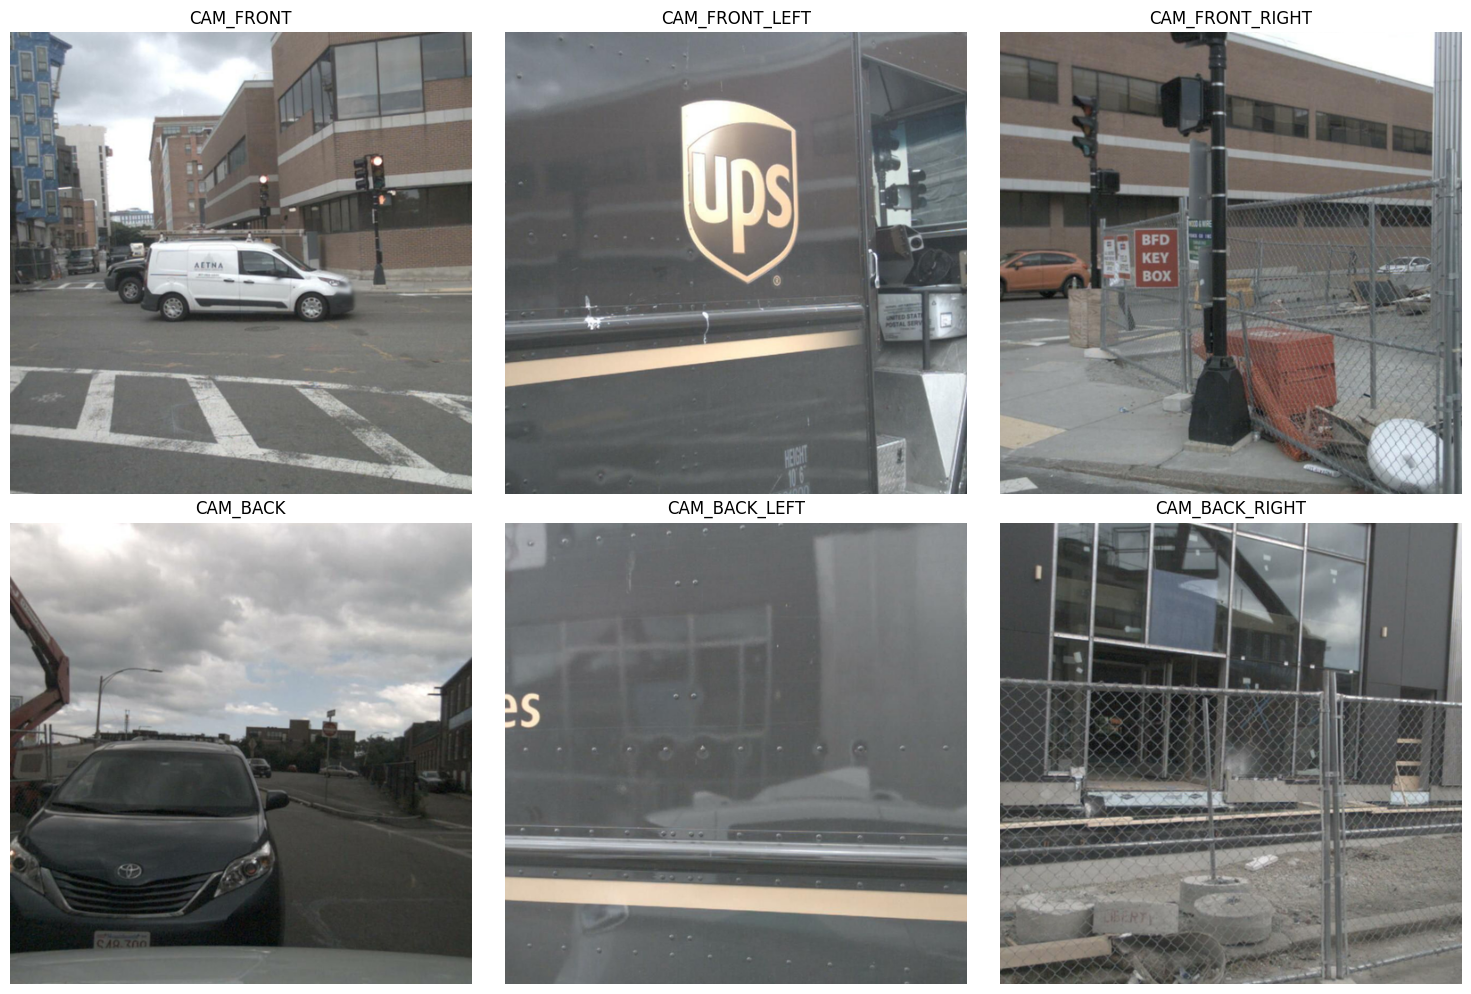

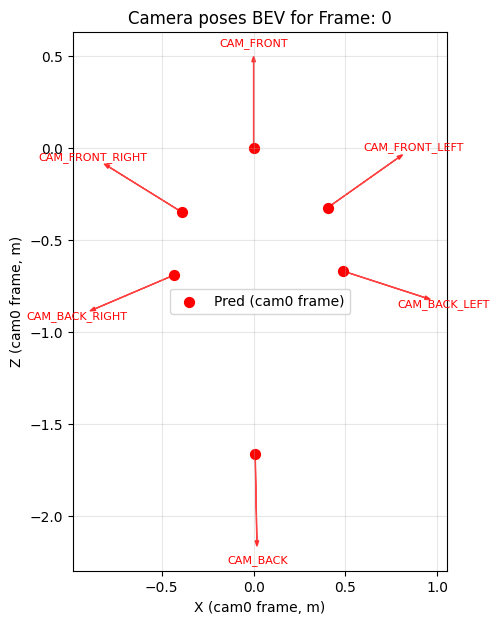

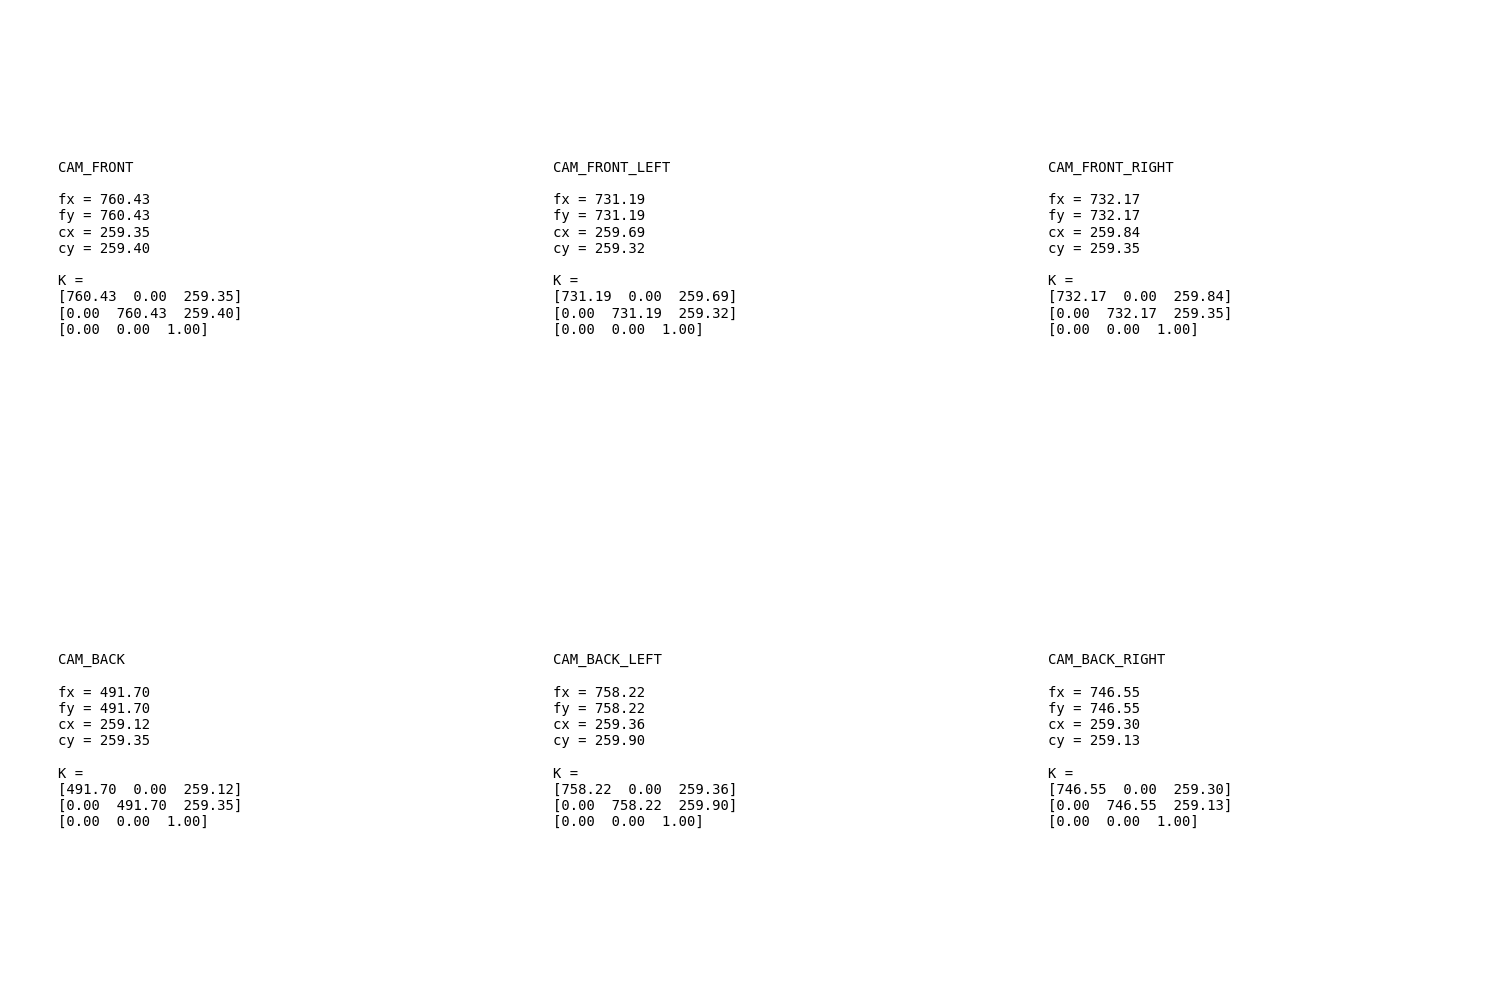

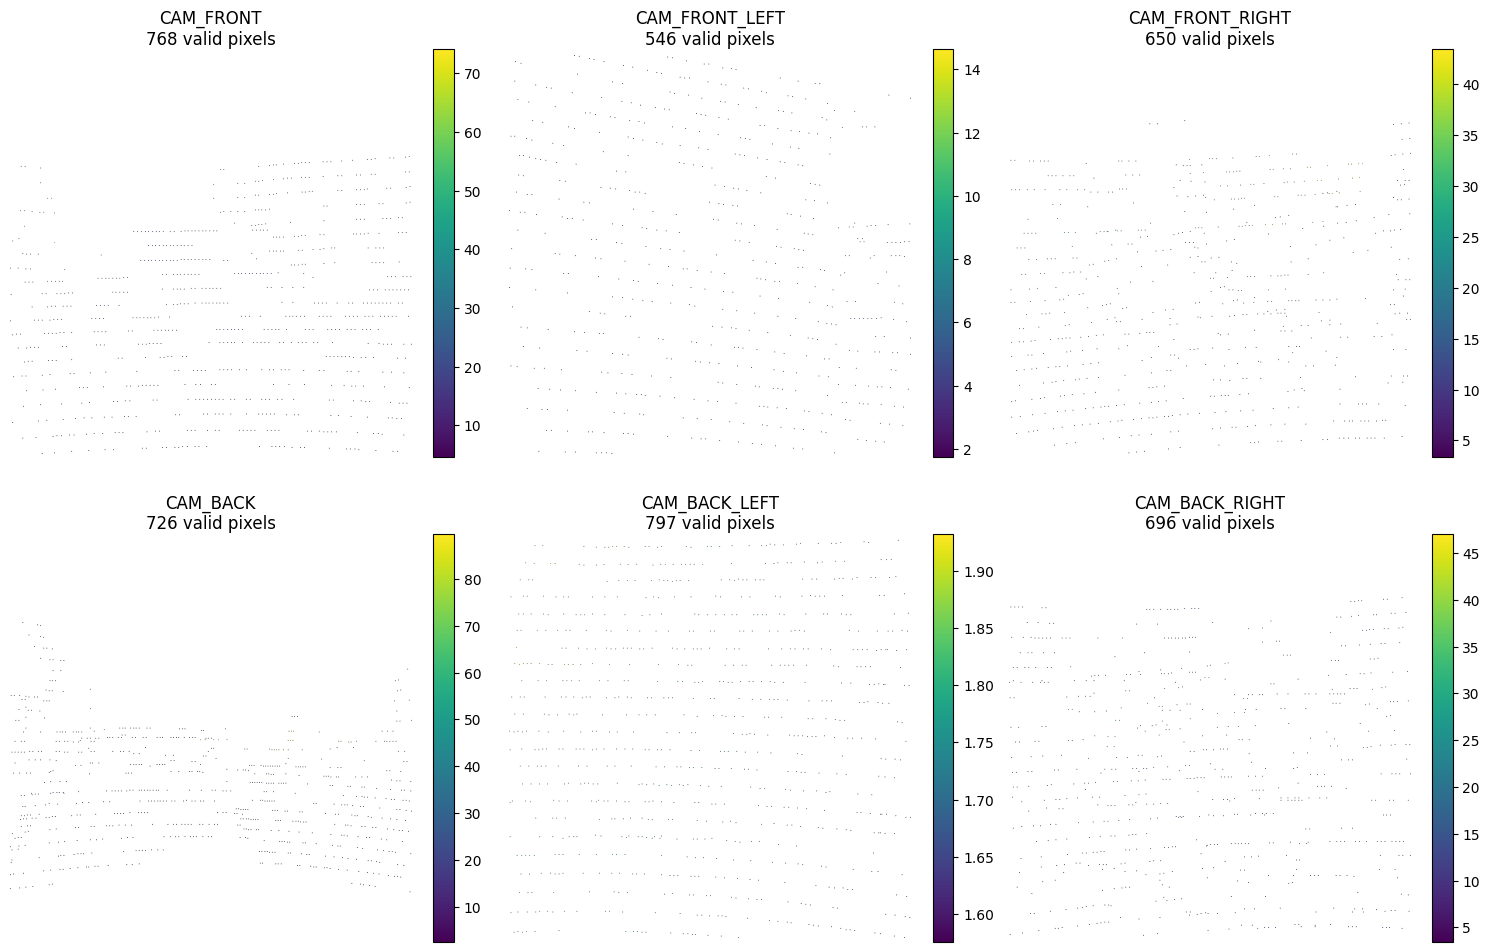


✓ All visualizations complete!


In [8]:
sample_idx = 120
sample = dataset.get_data(seq_index=sample_idx)

print("\n=== Sample Info ===")
print(f"Sample index: {sample_idx}")
print(f"Images shape: {sample['images'].shape}")         # [6, H, W, 3]
print(f"Images dtype: {sample['images'].dtype}")
print(f"Extrinsics shape: {sample['extrinsics'].shape}") # [6, 3, 4]
print(f"Intrinsics shape: {sample['intrinsics'].shape}") # [6, 3, 3]
print(f"Depths shape: {sample['depths'].shape}")         # [6, H, W, 1] or [6, H, W]
print(f"Point masks shape: {sample['point_masks'].shape}") # [6, H, W, 1] or [6, H, W]
print(f"\nImage pixel range: [{sample['images'].min():.2f}, {sample['images'].max():.2f}]")
print(f"Depth range: [{sample['depths'][sample['point_masks'] > 0].min():.2f}, "
      f"{sample['depths'][sample['point_masks'] > 0].max():.2f}]")

print("\n=== Generating Visualizations ===")

# Plot camera frames
plot_camera_frames(sample['images'], 'camera_frames.png')

# Plot extrinsics from bird's eye view
plot_bev_poses(pred = sample['extrinsics'], cam_names = all_cameras)

# Display intrinsics
display_intrinsics(sample['intrinsics'], 'intrinsics.png')

# Plot sparse depth
plot_sparse_depth(sample['depths'], sample['point_masks'], 'sparse_depth.png')

print("\n✓ All visualizations complete!")

In [6]:
def plot_camera_frames(images, output_path='camera_frames.png'):
    """
    Plot all 6 camera frames in a 2x3 grid.
    
    Args:
        images: numpy array of shape [6, H, W, 3] with values in [0, 255]
        output_path: path to save the figure
    """
    cam_names = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(6):
        img = images[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(cam_names[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def display_intrinsics(intrinsics, output_path='intrinsics.png'):
    """
    Display intrinsic matrices as text.
    
    Args:
        intrinsics: numpy array of shape [6, 3, 3]
        output_path: path to save the figure
    """
    cam_names = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(6):
        K = intrinsics[i]
        fx, fy = K[0, 0], K[1, 1]
        cx, cy = K[0, 2], K[1, 2]
        
        text = f"{cam_names[i]}\n\n"
        text += f"fx = {fx:.2f}\n"
        text += f"fy = {fy:.2f}\n"
        text += f"cx = {cx:.2f}\n"
        text += f"cy = {cy:.2f}\n\n"
        text += "K =\n"
        text += f"[{K[0,0]:.2f}  {K[0,1]:.2f}  {K[0,2]:.2f}]\n"
        text += f"[{K[1,0]:.2f}  {K[1,1]:.2f}  {K[1,2]:.2f}]\n"
        text += f"[{K[2,0]:.2f}  {K[2,1]:.2f}  {K[2,2]:.2f}]"
        
        axes[i].text(0.1, 0.5, text, fontsize=10, verticalalignment='center',
                    family='monospace')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_sparse_depth(depths, masks, output_path='sparse_depth.png'):
    """
    Plot sparse depth maps for all 6 cameras.
    
    Args:
        depths: numpy array of shape [6, H, W, 1] or [6, H, W]
        masks: numpy array of shape [6, H, W, 1] or [6, H, W], valid depth mask
        output_path: path to save the figure
    """
    cam_names = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(6):
        # Handle both 3D and 4D arrays
        if depths.ndim == 4:
            depth = depths[i, :, :, 0]
            mask = masks[i, :, :, 0] > 0
        else:
            depth = depths[i]
            mask = masks[i] > 0
        
        # Mask out invalid depths
        depth_masked = np.where(mask, depth, np.nan)
        
        # Count valid pixels
        n_valid = mask.sum()
        
        im = axes[i].imshow(depth_masked, cmap='viridis')
        axes[i].set_title(f'{cam_names[i]}\n{n_valid} valid pixels')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046)
    
    plt.tight_layout()
    plt.show()




def mat34_to_Rt(E):
    return E[:, :3], E[:, 3]

# Given extrinsic, get center
def center_in_input_frame(E):
    R, t = mat34_to_Rt(E)
    return -R.T @ t

# Camera forward (+Z) expressed in the input frame of E.
def forward_in_input_frame(E):
    R, _ = mat34_to_Rt(E)
    ez = np.array([0.0, 0.0, 1.0], dtype=np.float64)
    return R.T @ ez

def plot_bev_poses(pred=None, gt=None, cam_names=[], save = False, idx = 0):
    if pred is None and gt is None:
        print("Error: Both pred and gt are None.")
        return
    
    # Determine number of cameras
    if pred is not None:
        N = pred.shape[0]
    elif gt is not None:
        N = gt.shape[0]
    
    idxs = list(range(0, N))
    
    if pred is not None:
        centers_pred = np.array([center_in_input_frame(E) for E in pred])
        fwd_pred = np.array([forward_in_input_frame(E) for E in pred])
    
    if gt is not None:
        centers_gt = np.array([center_in_input_frame(E) for E in gt])
        fwd_gt = np.array([forward_in_input_frame(E) for E in gt])

    fig, ax = plt.subplots(figsize=(7,7))
    
    # Plot GT points and arrows
    if gt is not None:
        ax.scatter(centers_gt[idxs,0], centers_gt[idxs,2], c='g', label='GT (cam0 frame)', s=50)
    
    # Plot predicted points and arrows
    if pred is not None:
        ax.scatter(centers_pred[idxs,0], centers_pred[idxs,2], c='r', label='Pred (cam0 frame)', s=50)

    scale = 0.5
    for k in idxs:
        # Pred arrows
        if pred is not None:
            cp = centers_pred[k]
            fp = fwd_pred[k]
            ax.arrow(cp[0], cp[2], fp[0]*scale, fp[2]*scale, color='r', alpha=0.7, head_width=0.02, length_includes_head=True)
            
            # Add text label at the tip of the prediction arrow
            label_x = cp[0] + fp[0] * scale * 1.15
            label_y = cp[2] + fp[2] * scale * 1.15
            ax.text(label_x, label_y, cam_names[k], 
                    fontsize=8, 
                    ha='center', va='center',  
                    color='r')
        
        # GT arrows
        if gt is not None:
            cg = centers_gt[k]
            fg = fwd_gt[k]
            ax.arrow(cg[0], cg[2], fg[0]*scale, fg[2]*scale, color='g', alpha=0.7, head_width=0.1, length_includes_head=True)

            label_x = cg[0] + fg[0] * scale * 1.15
            label_y = cg[2] + fg[2] * scale * 1.15
            # Add text label for GT (only if pred is None to avoid overlap)
            ax.text(label_x, label_y, cam_names[k], fontsize=8, ha='center')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (cam0 frame, m)')
    ax.set_ylabel('Z (cam0 frame, m)')
    ax.set_title(f'Camera poses BEV for Frame: {idx}')
    ax.legend()
    if save:
        plt.savefig(f'output/frame_{idx}.png')
        plt.close(fig)
    else:
        plt.show()

In [7]:
all_cameras = [
    'CAM_FRONT',        # Reference camera (cam0)
    'CAM_FRONT_LEFT',
    'CAM_FRONT_RIGHT',
    'CAM_BACK',
    'CAM_BACK_LEFT',
    'CAM_BACK_RIGHT',
]